# HW 13-1
## Abby Baskind
## 2 December 2023

In [1]:
%cd /Users/akbaskind/Documents/Python Scripts/OCG577

from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests

# Import K's code for calculating the coefficients of the carb system
import calc_coeffs as co2
import H_poly as hpoly
import H_poly2 as hpoly2
from importlib import reload
import warnings
# warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

/Users/akbaskind/Documents/Python Scripts/OCG577


In [2]:
def threeboxmodel(time, dt, DIC = None, N = None, T = None, S = None, TA = None, **kwargs):
    
    """
    Currently, the 3 box model only advects DIC. 
    
    INPUTS:
        - time [year]
        - dt [year]
        - DIC [umol/kg]
        - T [°C]
        - S [PSU]
        - TA [umol/kg]
    
    OPTIONAL INPUTS:
        - dx [m]
        - dy [m]
        - dz [m]
        - k(i,j) [m3/s]
        - phi [m3/s]
    """
    
    import numpy as np
    import calc_coeffs as co2
    import carbon as carbon
    
    # # REQUIRED INPUTS *********************************************************************************
    # Check DIC input has length 3 and set initial concentrations
    # units [umol/kg]
    if len(DIC) != 3:
        raise ValueError('Length of DUC initial concentrations does not match number of boxes (3).')
    else:
        DIC1_0 = DIC[0]
        DIC2_0 = DIC[1]
        DIC3_0 = DIC[2]
    
    # Check N input has length 3 and set initial concentrations
    # units [umol/kg]
    if len(N) != 3:
        raise ValueError('Length of N initial concentrations does not match number of boxes (3).')
    else:
        N1_0 = N[0]
        N2_0 = N[1]
        N3_0 = N[2]
    
    # Check temperature input has length 3
    # units [°C]
    if len(T) != 3:
        raise ValueError('Length of initial temperature does not match number of boxes (3).')
    
    # Check salinity input has length 3
    # units [PSU]
    if len(S) != 3:
        raise ValueError('Length of initial salinity does not match number of boxes (3).')
    
    # Check TA input has length 3
    # units [umol/kg]
    if len(TA) != 3:
        raise ValueError('Length of initial TA does not match number of boxes (3).')
    
    # Convert time from years to seconds
    # year * (365 day/1 year) * (24 hours/1 day) * (60 min/1 hour) * (60 s/1 min)
    time = time * 365 * 24 * 60 * 60
    dt = dt * 365 * 24 * 60 * 60
    TIME = np.arange(0,time,dt)         # duration [s]
    
    # # OPTIONAL ARGS *******************************************************************
    # Keyword arguments can change the size of the boxes
    # dx, dy, dz, phi, k13, k23, k21, k31, k32, k12
    
    defaults = {'dx': np.array([17e6, 17e6, 17e6]),    # default dx = 17000 km
                'dy': np.array([8e6, 8e6, 16e6]),      # default dy = [8000 km, 8000 km, 16000 km]
                'dz': np.array([100, 100, 5000]),      # default dz = [100m, 100m, 5000m]
                'phi': 20e6, 
                'k13': 1e6,
                'k23': 1e6,
                'k12': 1e6,
                'k31': 1e6,
                'k32': 1e6,
                'k21': 1e6,
                'lambda1': 3e-7,                       # [1/s]
                'lambda2': 3e-8,                       # [1/s]
                'pCO2atm': 280,                        # default pCO2atm = 280 ppmv
                'kg': 5e-5}                            # default kg = 5*10^-5 m/s
    
    for key in defaults:
        if key in kwargs:
            data = kwargs.get(key)
            if type(data) == list:
                data = np.array(data)
            defaults[key] = data
    
    dx = defaults['dx']         # longitude (m)
    dy = defaults['dy']         # latitude (m)
    dz = defaults['dz']         # depth (m)
    phi = defaults['phi']       # m^3/s
    k13 = defaults['k13']       # m^3/s
    k23 = defaults['k23']       # m^3/s
    k12 = defaults['k12']       # m^3/s
    k32 = defaults['k32']       # m^3/s
    k31 = defaults['k31']       # m^3/s
    k21 = defaults['k21']       # m^3/s
    lambda1 = defaults['lambda1']   # 1/s
    lambda2 = defaults['lambda2']   # 1/s
    pCO2atm = defaults['pCO2atm']   # uatm
    kg = defaults['kg']         # m/s  
     
    # # BOX VOLUME
    # Default volumes: [1.36e+16 m3, 1.36e+16 m3, 1.36e+18 m3]
    # Calculate Volume
    V = dx * dy * dz                    # volume of each box (m^3)
    
    # # ATMOSPHERE
    # Total mass of atmosphere = 1.8e20 mol
    # Total mass of atmosphere = 1.8e26 umol
    Matm = 1.8e26
    XCO2_0 = pCO2atm                    # initial mixing ratio = 280 ppmv

    # # STORAGE ARRAYS *************************************************************************
    # Arrays to store concentrations over time
    DIC1 = np.zeros(len(TIME))
    DIC2 = np.zeros(len(TIME))
    DIC3 = np.zeros(len(TIME))
    PCO21 = np.zeros(len(TIME))
    PCO22= np.zeros(len(TIME))
    PCO23 = np.zeros(len(TIME))
    XCO2 = np.zeros(len(TIME))
    N1 = np.zeros(len(TIME))
    N2 = np.zeros(len(TIME))
    N3 = np.zeros(len(TIME))

    # # TIME STEP LOOP ***********************************************************************************
    for k in range(len(TIME)):
        
        # Calculate solubility 
        # k0 = [mol/kg/atm] = [umol/kg/uatm]
        coeffs = co2.calc_coeffs(T,S)
        k0_1 = coeffs['k0'][0] 
        k0_2 = coeffs['k0'][1] 
        k0_3 = coeffs['k0'][2] 
        
        # Calculate density [kg/m3]
        # My carbon package can solve for density 
        # So I have opted to solve for density rather than use constant density
        [rho1,rho2,rho3] = carbon.density_1atm(T,S)
        
        # Calculate pCO2
        # Input units [umol/kg]
        # pCO2 units [uatm]
        results = carbon.solver(DIC = np.array([DIC1_0,DIC2_0,DIC3_0]), TA = TA, temperature = T, salinity = S)
        pCO2_1 = results['pCO2'][0]
        pCO2_2 = results['pCO2'][1]
        pCO2_3 = results['pCO2'][2]
        PCO21[k] = pCO2_1
        PCO22[k] = pCO2_2
        PCO23[k] = pCO2_3
        
        # Calculate FCO2 for surface boxes (Box 1 and Box 2)
        # FCO2 for Box 3 = 0 -- not at air sea interface
        # [umol/kg] * [kg/m3] * [umol/(kg * atm)]
        # [umol/m2s] = [kg/m3] * [m/s] * [umol/kg uatm] * [uatm]
        # Changed pCO2atm to XCO2_0 (initial mixing ratio) since that
        # updates through every time step
        FCO2_1 = rho1 * kg * k0_1 * (XCO2_0 - pCO2_1)
        FCO2_2 = rho2 * kg * k0_2 * (XCO2_0 - pCO2_2)
        FCO2_3 = 0
        
        # Calculate air sea flux (ASF)
        # FCO2 * ∆x * ∆y /ρo
        # [umol/kg/s] = [umol/m2s] * [m] * [m] * [m3/kg]
        ASF1 = FCO2_1 * dx[0] * dy[0] / rho1
        # print(ASF1/V[0])
        ASF2 = FCO2_2 * dx[1] * dy[1] / rho2
        ASF3 = FCO2_3 * dx[2] * dy[2] / rho3
        
        # Calculate export production
        # E = lambda * N
        E1_3 = lambda1 * N1_0
        E2_3 = lambda2 * N2_0
        E3 = (E1_3 * V[0] + E2_3 * V[1])/(V[2])
        
        # Redfield Ration
        # 106C: 16N: 1P
        rC = 106
        rN = 16
        rP = 1
        rCN = rC/rN
        
        
        if k > 0:
            
            dN1dt = (1/V[0])*(phi*(N3[k-1]-N1[k-1]) + k31*(N3[k-1]-N1[k-1]) + k21*(N2[k-1]-N1[k-1])) - E1_3
            dN2dt = (1/V[1])*(phi*(N1[k-1]-N2[k-1]) + k12*(N1[k-1]-N2[k-1]) + k32*(N3[k-1]-N2[k-1])) - E2_3
            dN3dt = (1/V[2])*(phi*(N2[k-1]-N3[k-1]) + k23*(N2[k-1]-N3[k-1]) + k13*(N1[k-1]-N3[k-1])) + (E1_3 * V[0] + E2_3 * V[1])/(V[2])
    
            dDIC1dt = (1/V[0])*(phi*(DIC3[k-1]-DIC1[k-1]) + k31*(DIC3[k-1]-DIC1[k-1]) + k21*(DIC2[k-1]-DIC1[k-1])) + ASF1/V[0] - E1_3 * rCN
            dDIC2dt = (1/V[1])*(phi*(DIC1[k-1]-DIC2[k-1]) + k12*(DIC1[k-1]-DIC2[k-1]) + k32*(DIC3[k-1]-DIC2[k-1]) + ASF2) - E2_3 * rCN
            dDIC3dt = (1/V[2])*(phi*(DIC2[k-1]-DIC3[k-1]) + k23*(DIC2[k-1]-DIC3[k-1]) + k13*(DIC1[k-1]-DIC3[k-1])) + E3 * rCN
            dXCO2dt = (-1/Matm)*(FCO2_1 * dx[0] * dy[0] + FCO2_2 * dx[1] * dy[1])
                    
        
        else:
            dDIC1dt = 0
            dDIC2dt = 0
            dDIC3dt = 0
            dXCO2dt = 0
            dN1dt = 0
            dN2dt = 0
            dN3dt = 0
        
        # Calculate concentration at time t
        DIC1[k] = DIC1_0 + dDIC1dt * dt
        DIC2[k] = DIC2_0 + dDIC2dt * dt
        DIC3[k] = DIC3_0 + dDIC3dt * dt
        XCO2[k] = XCO2_0 + dXCO2dt * dt
        N1[k] = N1_0 + dN1dt * dt
        N2[k] = N2_0 + dN2dt * dt
        N3[k] = N3_0 + dN3dt * dt
    
        # Set initial (aka C(t-1)) to latest solution
        DIC1_0 = DIC1[k]
        DIC2_0 = DIC2[k]
        DIC3_0 = DIC3[k]
        XCO2_0 = XCO2[k]
        N1_0 = N1[k]
        N2_0 = N2[k]
        N3_0 = N3[k]
        
    TOTAL = DIC1 * V[0] + DIC2 * V[1] + DIC3 * V[2]
        
    data = {
        'Box 1 DIC Concentration [umol/kg]': DIC1,
        'Box 2 DIC Concentration [umol/kg]': DIC2,
        'Box 3 DIC Concentration [umol/kg]': DIC3,
        'Box 1 N Concentration [umol/kg]': N1,
        'Box 2 N Concentration [umol/kg]': N2,
        'Box 3 N Concentration [umol/kg]': N3,
        'Box 1 pCO2 [uatm]': PCO21,
        'Box 2 pCO2 [uatm]': PCO22,
        'Box 3 pCO2 [uatm]': PCO23,
        'Box 1 Volume': V[0],
        'Box 2 Volume': V[1],
        'Box 3 Volume': V[2],
        'Box 1 density': rho1,
        'Box 2 density': rho2,
        'Box 3 density': rho3,
        'pCO2atm': pCO2atm,
        'Box 1 Total DIC [umol]': DIC1 * V[0],
        'Box 2 Total DIC [umol]': DIC2 * V[1],
        'Box 3 Total DIC [umol]': DIC3 * V[2],
        'TOTAL': TOTAL,
        't [yr]': TIME,
        'XCO2': XCO2
        }
    return data

```python
# Calculate FCO2 for surface boxes (Box 1 and Box 2)
# FCO2 for Box 3 = 0 -- not at air sea interface
# [umol/kg] * [kg/m3] * [umol/(kg * atm)]
FCO2_1 = rho1 * kg * k0_1 * (pCO2atm - pCO2_1)
FCO2_2 = rho2 * kg * k0_2 * (pCO2atm - pCO2_2)
FCO2_3 = 0
        
# Calculate air sea flux (ASF)
# FCO2 * ∆x * ∆y /ρo
ASF1 = FCO2_1 * dx[0] * dy[0] / rho1
ASF2 = FCO2_2 * dx[1] * dy[1] / rho2
ASF3 = FCO2_3 * dx[2] * dy[2] / rho3
    
# Calculate export production
# E = lambda * N
E1_3 = lambda1 * N1_0
E2_3 = lambda2 * N2_0
E3 = (E1_3 * V[0] + E2_3 * V[1])/(V[2])
        
# Redfield Ration
# 106C: 16N: 1P
rC = 106
rN = 16
rP = 1
rCN = rC/rN
        
dN1dt = (1/V[0])*(phi*(N3[k-1]-N1[k-1]) + k31*(N3[k-1]-N1[k-1]) + k21*(N2[k-1]-N1[k-1])) - E1_3
dN2dt = (1/V[1])*(phi*(N1[k-1]-N2[k-1]) + k12*(N1[k-1]-N2[k-1]) + k32*(N3[k-1]-N2[k-1])) - E2_3
dN3dt = (1/V[2])*(phi*(N2[k-1]-N3[k-1]) + k23*(N2[k-1]-N3[k-1]) + k13*(N1[k-1]-N3[k-1])) + (E1_3 * V[0] + E2_3 * V[1])/(V[2])
    
dDIC1dt = (1/V[0])*(phi*(DIC3[k-1]-DIC1[k-1]) + k31*(DIC3[k-1]-DIC1[k-1]) + k21*(DIC2[k-1]-DIC1[k-1])) + ASF1/V[0] - E1_3 * rCN
dDIC2dt = (1/V[1])*(phi*(DIC1[k-1]-DIC2[k-1]) + k12*(DIC1[k-1]-DIC2[k-1]) + k32*(DIC3[k-1]-DIC2[k-1]) + ASF2) - E2_3 * rCN
dDIC3dt = (1/V[2])*(phi*(DIC2[k-1]-DIC3[k-1]) + k23*(DIC2[k-1]-DIC3[k-1]) + k13*(DIC1[k-1]-DIC3[k-1])) + E3 * rCN
dXCO2dt = (-1/Matm)*(FCO2_1 * dx[0] * dy[0] + FCO2_2 * dx[1] * dy[1])
```

$$
\frac{\partial \text{DIC}_1}{\partial \text{t}} = \frac{1}{\text{V}_1} * ( \phi (\text{DIC}_3 - \text{DIC}_1) + \text{k}_{3,1} (\text{DIC}_3 - \text{DIC}_1) + \text{k}_{2,1} (\text{DIC}_2 - \text{DIC}_1) + \text{k}_{\text{g}} \text{k}_0 \partial \text{x}_1 \partial \text{y}_1 * (\text{pCO2}_2^{\text{atm}} - \text{pCO2}_2^{\text{Box 1}})) - \lambda_1 * \text{N}_1 * \frac{106 \text{C}}{16 \text{N}}
$$ 

$$
\frac{\partial \text{DIC}_2}{\partial \text{t}} = \frac{1}{\text{V}_2} * ( \phi (\text{DIC}_1 - \text{DIC}_2) + \text{k}_{1,2} (\text{DIC}_1 - \text{DIC}_2) + \text{k}_{3,2} (\text{DIC}_3 - \text{DIC}_2) + \text{k}_{\text{g}} \text{k}_0 \partial \text{x}_2 \partial \text{y}_2 * (\text{pCO2}_2^{\text{atm}} - \text{pCO2}_2^{\text{Box 2}})) - \lambda_2 * \text{N}_2 * \frac{106 \text{C}}{16 \text{N}}
$$ 

$$
\frac{\partial \text{DIC}_3}{\partial \text{t}} = \frac{1}{\text{V}_3} * ( \phi (\text{DIC}_2 - \text{DIC}_3) + \text{k}_{2,3} (\text{DIC}_2 - \text{DIC}_3) + \text{k}_{1,3} (\text{DIC}_1 - \text{DIC}_3) + 0) + \frac{\lambda_1 * \text{N}_1 * \text{V}_1 + \lambda_2 * \text{N}_2 * \text{V}_2}{\text{V}_3} * \frac{106 \text{C}}{16 \text{N}}
$$ 

Since Box 3 has no air-sea interface, it does not undergo air sea gas exchange. 

# Simulation with N

Text(0, 0.5, 'N [umol/kg]')

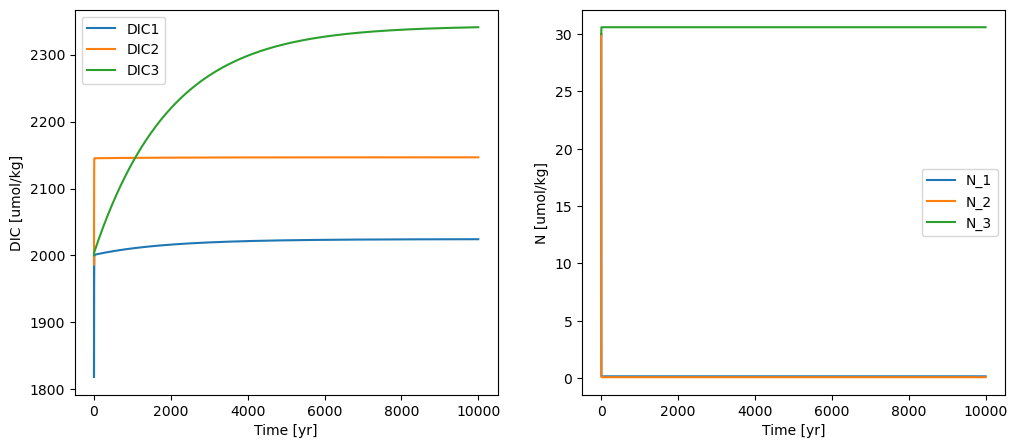

In [4]:
import carbon as carbon
T = np.array([20,4,4])
S = np.array([35,34.5,34.5])
DIC = np.array([2000,2000,2000])
N = np.array([30,30,30])
TA = np.array([2350,2350,2350])

results = threeboxmodel(10000,1/12,DIC = DIC, N = N, TA = TA, T = T, S = S)

fig, axarr = plt.subplots(ncols = 2, figsize = [12,5])
axarr = axarr.flatten()
ax = axarr[0]
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 1 DIC Concentration [umol/kg]'], label = 'DIC1')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 2 DIC Concentration [umol/kg]'], label = 'DIC2')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 3 DIC Concentration [umol/kg]'], label = 'DIC3')
ax.legend()
ax.set_xlabel('Time [yr]')
ax.set_ylabel('DIC [umol/kg]')

ax = axarr[1]
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 1 N Concentration [umol/kg]'], label = 'N_1')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 2 N Concentration [umol/kg]'], label = 'N_2')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 3 N Concentration [umol/kg]'], label = 'N_3')
ax.legend()
ax.set_xlabel('Time [yr]')
ax.set_ylabel('N [umol/kg]')



## Why do you think the export rate constant,  \lambda, is higher in box 1 (i.e., low latitudes) than box 2 (subpolar ocean)?

I think export is higher in Box 1 because biology is not as light limited or iron limited as the high latitudes, so biology is able to export nitrogen more consistently. The low latitude ocean tends to be more nitrogen limited, so the export depends primarily on N availability. Export is lower in the high latitudes because, despite decreased N limitation, light limitation and iron limitation often curb the biological activity that would export N. Notably, when light limitation or Fe limitation is relaxed in the high latitude ocean, export would actually be higher, since large diatoms with Si shells sink efficiently (ballast effects etc etc etc). Moreover, since the high latitude ocean in times of high production tend to have high new production as opposed to regenerated production, this signals that remineralization is low enough that N is able to escape the surface before being recycled.

## What is a suitable timestep for your Euler forward time-stepping scheme when including this biological model? Explain your reasoning.

Based on the last assignment, N cycling occurs a bit more quickly than C cycling. I chose a time step of 1 month. The model as it is currently set up parameterizes biological activity, rather than calculating an in situ metabolism. If we calculated an in situ metabolism (i.e. solved for production and respiration in the surface), we would need a much smaller time step, since the metabolism can change over timescales as short as the diurnal cycle. However, many models are not able to resolve biology as such granular temporal resolutions but do resolve time on scales slightly longer than the diurnal cycle. For instance, the ROMS OSOM CoSine model cannot resolve the day-night cycle but (in theory) can resolve day to day changes.

## Plot a graph to demonstrate that the global ocean nitrogen inventory is conserved.

Looks pretty conserved.

## Plot N and DIC in each box to show that the ocean system has come to steady state with this fixed atmospheric XCO2. 

My XCO2 was not fixed but a plot of pCO2 showed that it still converges to steady state in the surface. pCO2 is very high in the deep ocean but that is fine and reasonable and realistic. 



Text(0, 0.5, 'pCO2 [uatm]')

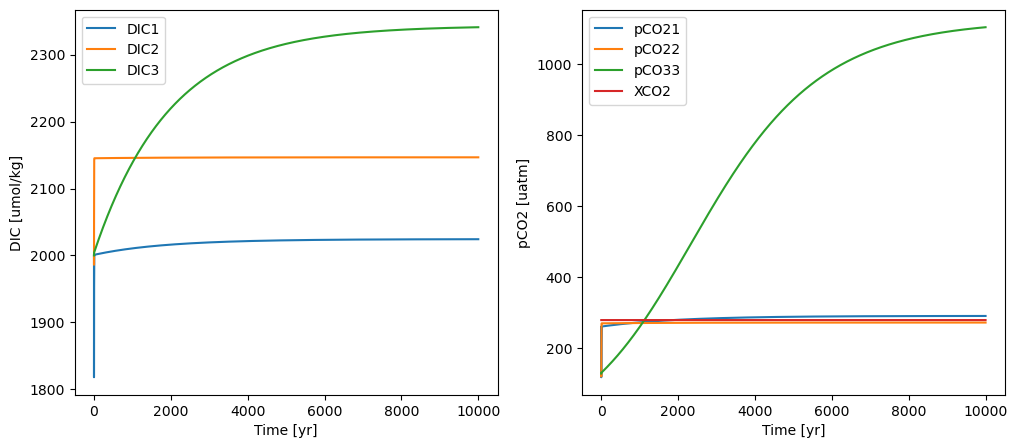

In [8]:
# T = np.array([20,4,4])
# S = np.array([35,34.5,34.5])
# DIC = np.array([2000,2000,2000])
# N = np.array([30,30,30])
# TA = np.array([2350,2350,2350])

# results = threeboxmodel(1000,1/12,DIC = DIC, N = N, TA = TA, T = T, S = S, lambda2 = 3e-10)

fig, axarr = plt.subplots(ncols = 2, figsize = [12,5])
axarr = axarr.flatten()
ax = axarr[0]
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 1 DIC Concentration [umol/kg]'], label = 'DIC1')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 2 DIC Concentration [umol/kg]'], label = 'DIC2')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 3 DIC Concentration [umol/kg]'], label = 'DIC3')
ax.legend()
ax.set_xlabel('Time [yr]')
ax.set_ylabel('DIC [umol/kg]')

ax = axarr[1]
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 1 pCO2 [uatm]'], label = 'pCO21')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 2 pCO2 [uatm]'], label = 'pCO22')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 3 pCO2 [uatm]'], label = 'pCO33')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['XCO2'], label = 'XCO2')
ax.legend()
ax.set_xlabel('Time [yr]')
ax.set_ylabel('pCO2 [uatm]')

# ax = axarr[1]
# ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 1 N Concentration [umol/kg]'], label = 'N_1')
# ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 2 N Concentration [umol/kg]'], label = 'N_2')
# ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 3 N Concentration [umol/kg]'], label = 'N_3')
# ax.legend()
# ax.set_xlabel('Time [yr]')
# ax.set_ylabel('N [umol/kg]')

